# Extreme precipitation in the Canadian Arctic
Here, I process, clean and explore data used in the extreme precipitation in Canadian Arctic study.

Data are obtained from https://climatedata.ca/download/#station-download.  This is not the official ECCC site but collates and serves daily data.

Historical daily data is also available from ECCC [here](https://climate.weather.gc.ca/historical_data/search_historic_data_e.html)

_I need to check what they do_  It looks like climatedata.ca do not do anything to the files from ECCC.

Many stations have had site and instrumentation changes.  Where these have occurred and sites are co-located, records have been combined.

#### To Do
- Make plot of record span for each station, including periods of missing data  
- Make map of stations with symbols showing length of record
- Make table showing length of record and completeness of record by year  
- _Tair and Prceip statistics for combined records_  
- Plot heatmap showing timing and amount of precipitation for each station
- Calculate seasonal cycle of precipitations (precip days, average P, phase)  


## Glossary
The links below are to the ECCC glossary pages

[Maximum Temperature](https://climate.weather.gc.ca/glossary_e.html#maxTemp)  
[Minimum Temperature](https://climate.weather.gc.ca/glossary_e.html#minTemp)  
[Mean Temperature](https://climate.weather.gc.ca/glossary_e.html#meanTemp) Average of maxmimum and minimum temperature.  
[Heating Degree Days](https://climate.weather.gc.ca/glossary_e.html#hdd): The number of degree Celsius that mean temperature is below 18 C, zero otherwise.  
[Cooling Degree Days](https://climate.weather.gc.ca/glossary_e.html#cooling): Number of degrees Celsius mean temperature is above 18 C, zero otherwise.  
[Total Rain](https://climate.weather.gc.ca/glossary_e.html#totalRain): Amount of liquid precipitation in mm falling in a [climatological day](https://climate.weather.gc.ca/glossary_e.html#climatological_day).  
[Total snow](https://climate.weather.gc.ca/glossary_e.html#totalSnow): Amount of frozen precipitation in cm, such as snow an ice pellets, falling in a [climatological day](https://climate.weather.gc.ca/glossary_e.html#climatological_day)  
[Total Precipitation](https://climate.weather.gc.ca/glossary_e.html#totalPrec): Sum of rainfall and water equivalent of solid precipitation in mm observed during a [climatological day](https://climate.weather.gc.ca/glossary_e.html#climatological_day).  Trace precipitation 'T' is precipitation amount less than 0.2 mm.  Total precipitation measurements end at 0600Z.  See also [Precipitation](https://climate.weather.gc.ca/glossary_e.html#precipitation)  
[Snow on the ground](https://climate.weather.gc.ca/glossary_e.html#s_onGround): Depth of snow on the ground in cm at time of observation. 

A [Climatological Day](https://climate.weather.gc.ca/glossary_e.html#climatological_day) is from 0601Z to 0600Z on the following day.  _I need to look at how this varies across Canada_.  For stations reporting twice or more times a day, climatological day applies but for stations reporting only once per day, the day of observation is calendar day.  Reporting time is consistent but the choice of the observer.  So we need to check reporting frequencies of stations.  I can look at the hourly data for this.

ECCC provide a metadata file for each station with Flag codes.  This is given below.
Legend
__A__	Accumulated  
__C__	Precipitation occurred, amount uncertain  
__E__	Estimated  
__F__	Accumulated and estimated  
__L__	Precipitation may or may not have occurred  
__M__	Missing 
__N__	Temperature missing but known to be > 0  
__S__	More than one occurrence  
__T__	Trace  
__Y__	Temperature missing but known to be < 0  
__[empty]__	Indicates an unobserved value  
__^__	The value displayed is based on incomplete data  
__†__	Data that is not subject to review by the National Climate Archives  

In [1]:
import sys
sys.path.append('../canadian_extreme_precip/')

from pathlib import Path
import re
import pprint
import json

import datetime as dt
import matplotlib.pyplot as plt
#import pandas as pd
#pd.options.plotting.backend = 'holoviews'

from filepath import raw_station_filepath
from reader import read_station_file

from make_combined_files import get_recipe

In [2]:
recipe = get_recipe()

In [3]:
stations = recipe[0]['stations']

In [4]:
df = read_station_file(raw_station_filepath(stations[0]['climate_identifier']))
df.tail()

,x,y,STATION_NAME,CLIMATE_IDENTIFIER,ID,PROVINCE_CODE,LOCAL_YEAR,LOCAL_MONTH,LOCAL_DAY,MEAN_TEMPERATURE,...,SPEED_MAX_GUST,SPEED_MAX_GUST_FLAG,COOLING_DEGREE_DAYS,COOLING_DEGREE_DAYS_FLAG,HEATING_DEGREE_DAYS,HEATING_DEGREE_DAYS_FLAG,MIN_REL_HUMIDITY,MIN_REL_HUMIDITY_FLAG,MAX_REL_HUMIDITY,MAX_REL_HUMIDITY_FLAG
LOCAL_DATE,,,,,,,,,,,,,,,,,,,,,
2006-10-27,-62.280556,82.517778,ALERT,2400300,2400300.2006.10.27,NU,2006,10,27,NaN,...,NaN,NaN,NaN,M,NaN,M,NaN,NaN,NaN,NaN
2006-10-28,-62.280556,82.517778,ALERT,2400300,2400300.2006.10.28,NU,2006,10,28,NaN,...,NaN,NaN,NaN,M,NaN,M,NaN,NaN,NaN,NaN
2006-10-29,-62.280556,82.517778,ALERT,2400300,2400300.2006.10.29,NU,2006,10,29,NaN,...,NaN,NaN,NaN,M,NaN,M,NaN,NaN,NaN,NaN
2006-10-30,-62.280556,82.517778,ALERT,2400300,2400300.2006.10.30,NU,2006,10,30,NaN,...,NaN,NaN,NaN,M,NaN,M,NaN,NaN,NaN,NaN
2006-10-31,-62.280556,82.517778,ALERT,2400300,2400300.2006.10.31,NU,2006,10,31,NaN,...,NaN,NaN,NaN,M,NaN,M,NaN,NaN,NaN,NaN


### QC

#### Precipitation
Precipitation may be Trace (< 0.2 mm).  This is reported as zero but Goodison and Yang assign ? mm.  Precipitation may also be coded __C__ if precipitation occurred but amount is uncertain or __L__ precipitation may or may not have occurred.  _I need to check if this occurs in any of the records_.

In [5]:
trace_precip = 0.1
df['TOTAL_PRECIPITATION'][df.TOTAL_PRECIPITATION_FLAG == 'T'] = trace_precip

/home/apbarret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='LOCAL_DATE'>

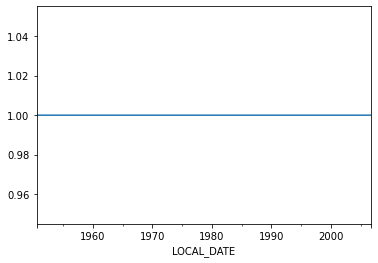

In [6]:
y = df.MEAN_TEMPERATURE_FLAG.where((df.MEAN_TEMPERATURE_FLAG == 'M') & (df.MEAN_TEMPERATURE_FLAG == 'E'), 1) 
#fig, ax = plt.subplots(figsize=(12,7))
#ax.plot(x, y, '.', markersize=1)

y.plot()

In [ ]:
data_columns = [
    'MAX_TEMPERATURE',
    'MIN_TEMPERATURE',
    'MEAN_TEMPERATURE',
    'HEATING_DEGREE_DAYS',
    'COOLING_DEGREE_DAYS',
    'TOTAL_RAIN',
    'TOTAL_SNOW',
    'TOTAL_PRECIPITATION',
    'SNOW_ON_GROUND',
    'DIRECTION_MAX_GUST',
    'SPEED_MAX_GUST',
    'MAX_REL_HUMIDITY',
    'MIN_REL_HUMIDITY',
]
nfields = len(data_columns)

In [ ]:
df.loc['2006-01', data_columns]

In [ ]:
xmin, xmax = dt.datetime(1950,1,1), dt.datetime(2021,12,31)

fig, axes = plt.subplots(nfields, 1, figsize=(12,20))
for col, ax in zip(data_columns, axes):
    df[col].plot(ax=ax, title=col)
    ax.set_xlim(xmin, xmax)

In [ ]:
df.MEAN_TEMPERATURE_FLAG.unique()

In [ ]:
for flag in [col for col in df.columns if '_FLAG' in col]:
    print(flag, df[flag].unique())

In [ ]:
df.MEAN_TEMPERATURE.notna().astype(int).plot()

In [ ]:
recipe 